/tmp/ipykernel_2317315/526594669.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


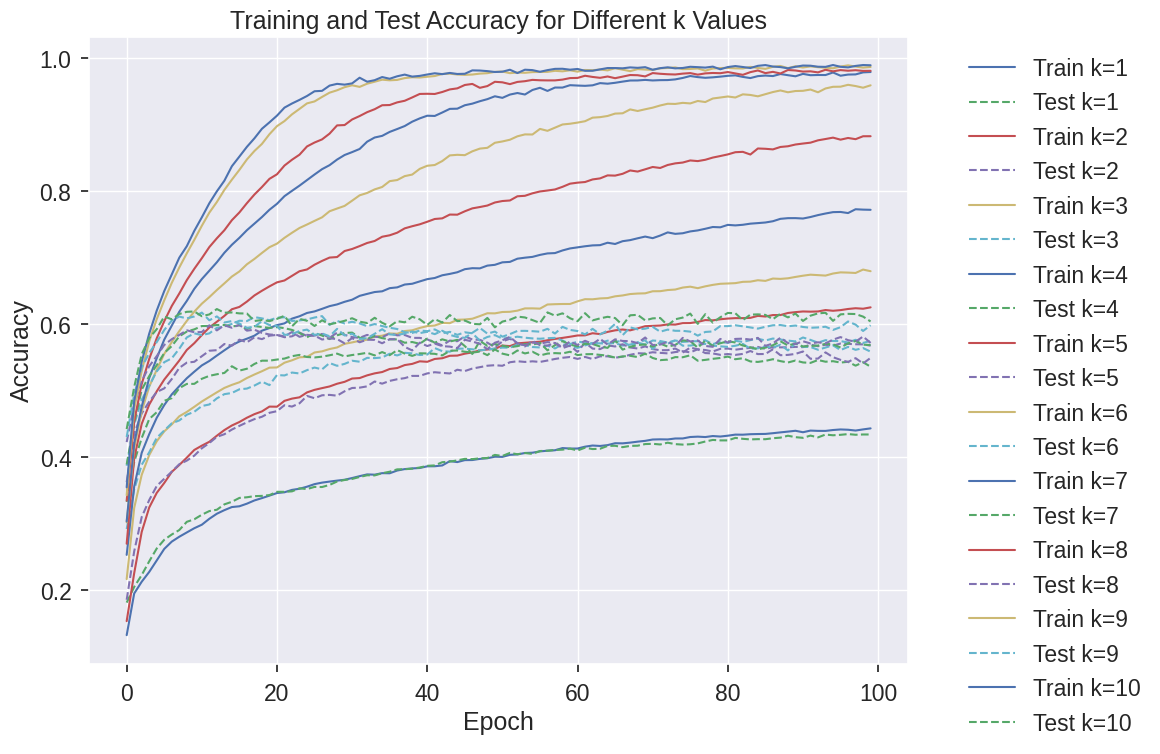

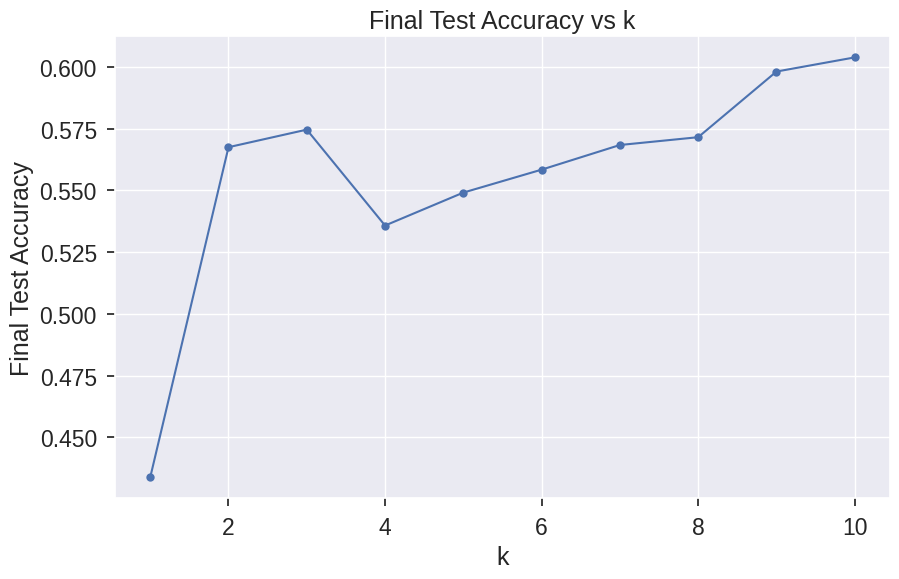

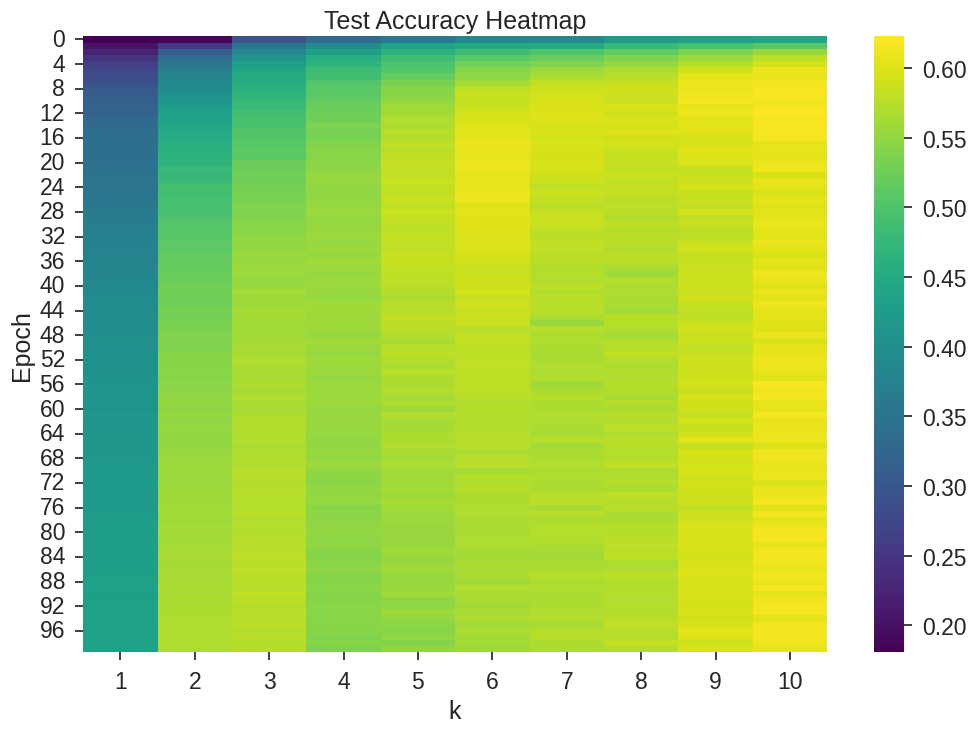

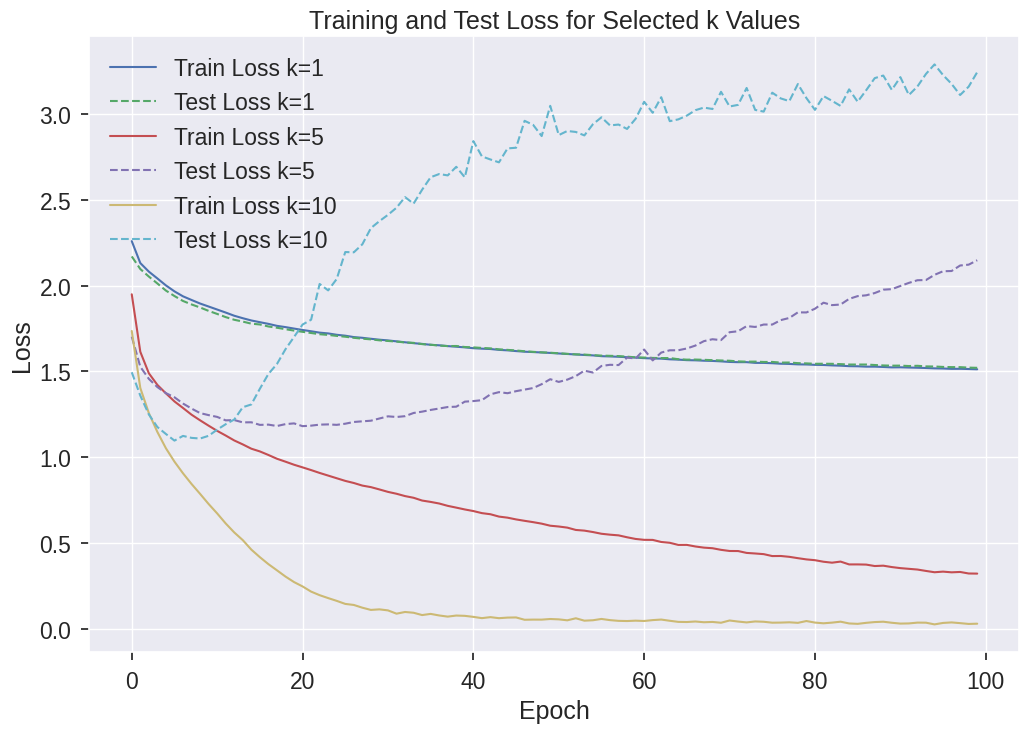

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set the style for the plots
plt.style.use('seaborn')
sns.set_context("notebook", font_scale=1.5)

# Specify the path to your run directory
run_dir = "/home/jakub/projects/double_descend/double_descent_torch/runs/run_20241006_215645"

# Function to load results
def load_results(k):
    results_path = os.path.join(run_dir, "results", f"resnet18k_{k}_results.pt")
    return torch.load(results_path)

# Load all results
k_values = range(1, 11)  # Adjust this range based on your actual k values
all_results = {k: load_results(k) for k in k_values}

# Create a DataFrame for easier plotting
data = []
for k, results in all_results.items():
    for epoch, (train_loss, train_acc, test_loss, test_acc) in enumerate(zip(
        results['train_loss'], results['train_acc'], 
        results['test_loss'], results['test_acc']
    )):
        data.append({
            'k': k,
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'test_loss': test_loss,
            'test_acc': test_acc
        })

df = pd.DataFrame(data)

# Plot training and test accuracy for all k values
plt.figure(figsize=(12, 8))
for k in k_values:
    plt.plot(df[df['k'] == k]['epoch'], df[df['k'] == k]['train_acc'], label=f'Train k={k}')
    plt.plot(df[df['k'] == k]['epoch'], df[df['k'] == k]['test_acc'], label=f'Test k={k}', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy for Different k Values')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot final test accuracy vs k
final_test_acc = [df[(df['k'] == k) & (df['epoch'] == df['epoch'].max())]['test_acc'].values[0] for k in k_values]
plt.figure(figsize=(10, 6))
plt.plot(k_values, final_test_acc, marker='o')
plt.xlabel('k')
plt.ylabel('Final Test Accuracy')
plt.title('Final Test Accuracy vs k')
plt.grid(True)
plt.show()

# Create heatmap of test accuracy
pivot_df = df.pivot(index='epoch', columns='k', values='test_acc')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, cmap='viridis')
plt.xlabel('k')
plt.ylabel('Epoch')
plt.title('Test Accuracy Heatmap')
plt.show()

# Plot training curves for specific k values
k_to_plot = [1, 5, 10]  # Adjust these values as needed
plt.figure(figsize=(12, 8))
for k in k_to_plot:
    plt.plot(df[df['k'] == k]['epoch'], df[df['k'] == k]['train_loss'], label=f'Train Loss k={k}')
    plt.plot(df[df['k'] == k]['epoch'], df[df['k'] == k]['test_loss'], label=f'Test Loss k={k}', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss for Selected k Values')
plt.legend()
plt.show()

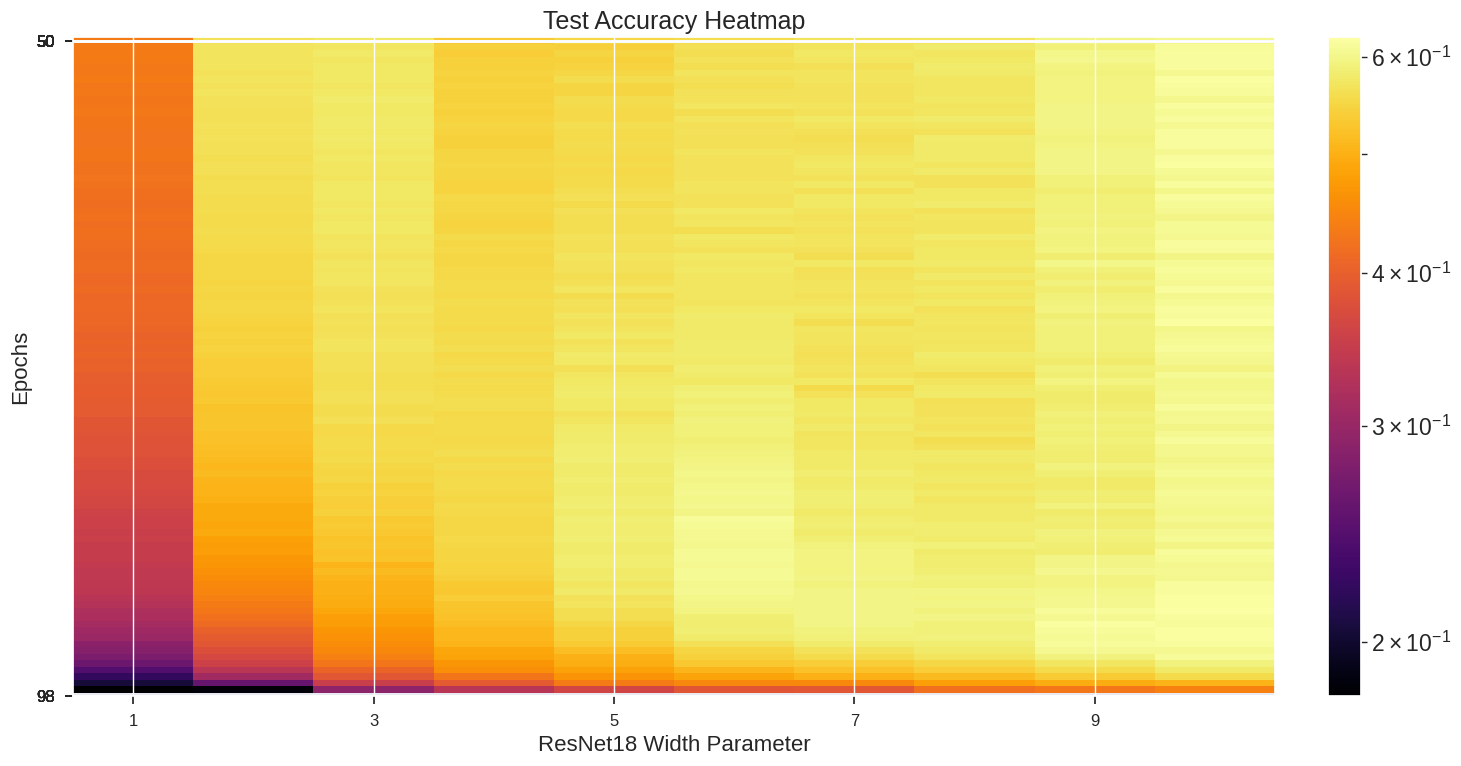

In [2]:
import matplotlib.colors as colors
import matplotlib.ticker as ticker

# Create heatmap of test accuracy
pivot_df = df.pivot(index='epoch', columns='k', values='test_acc')
pivot_df = pivot_df.iloc[::-1]  # Reverse the order of rows

plt.figure(figsize=(15, 8))
ax = plt.gca()

# Create the heatmap
im = ax.imshow(pivot_df, cmap='inferno', norm=colors.LogNorm(vmin=pivot_df.min().min(), vmax=pivot_df.max().max()),
               aspect='auto', interpolation='none')

# Y-axis (Epochs)
max_epochs = pivot_df.index.max()
base = 1.1  # You can adjust this value
eps = np.unique(np.array(base**np.arange(0, np.log(max_epochs)/np.log(base)), dtype=int))
y_ticks = np.searchsorted(pivot_df.index, eps)
ax.set_yticks(y_ticks)
ax.set_yticklabels([f'{e+1}' for e in eps], fontsize=12)
ax.set_ylabel('Epochs', fontsize=16)

# X-axis (k values)
x_ticks = range(0, len(pivot_df.columns), 2)  # Show every other k value
ax.set_xticks(x_ticks)
ax.set_xticklabels([str(k) for k in pivot_df.columns[x_ticks]], fontsize=12)
ax.set_xlabel('ResNet18 Width Parameter', fontsize=16)

# Colorbar
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=10)

# Title
plt.title('Test Accuracy Heatmap', fontsize=18)

plt.tight_layout()
plt.show()

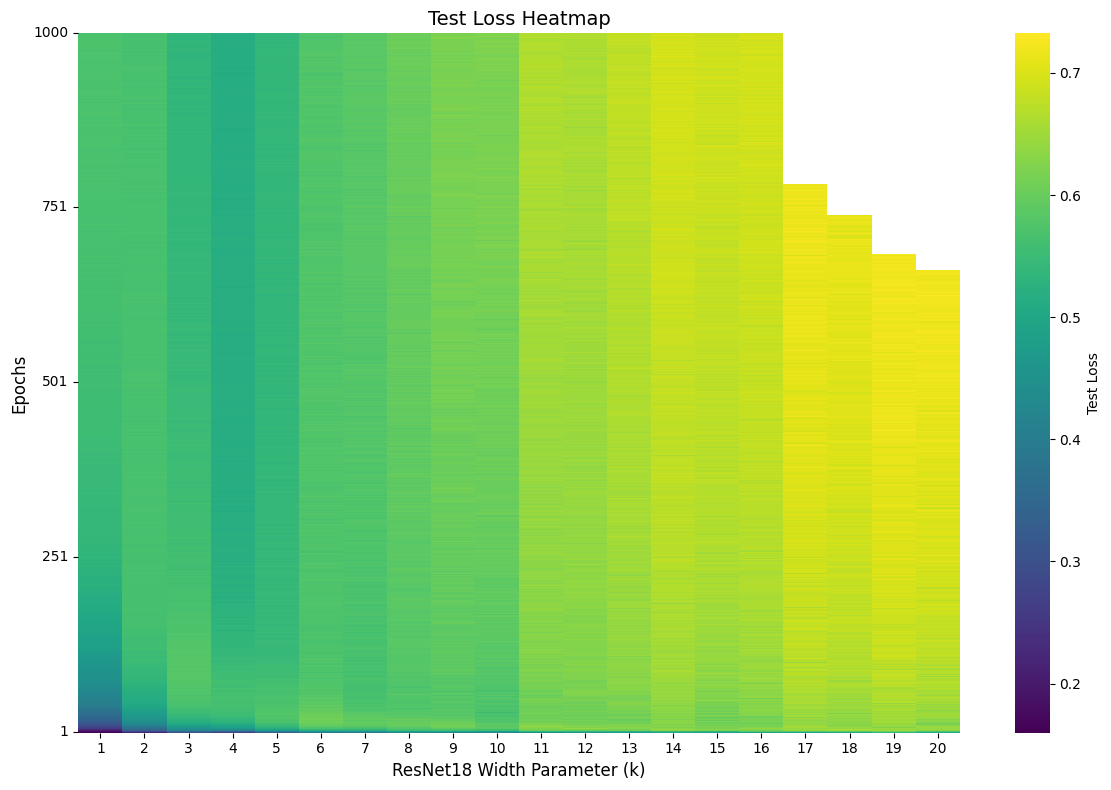

In [5]:
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Specify the path to your run directory
run_dir = "/home/jakub/projects/double_descend/double_descent_torch/runs/run_20241011_115420/results"

# Function to load results
def load_results(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

# Load all results
all_results = []
for filename in os.listdir(run_dir):
    if filename.startswith("resnet18k_") and filename.endswith("_results.json"):
        file_path = os.path.join(run_dir, filename)
        k = int(filename.split("_")[1])  # Extract k value from filename
        results = load_results(file_path)
        for result in results:
            result['k'] = k  # Add k to each result dictionary
        all_results.extend(results)

# Create a DataFrame
df = pd.DataFrame(all_results)

# Pivot the DataFrame for the heatmap
pivot_df = df.pivot(index='epoch', columns='k', values='test_acc')
pivot_df = pivot_df.sort_index(ascending=False)  # Reverse the order of epochs

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, cmap='viridis', cbar_kws={'label': 'Test Loss'})

# Adjust y-axis (Epochs)
max_epochs = pivot_df.index.max()
y_ticks = np.linspace(0, len(pivot_df) - 1, 5, dtype=int)  # 5 ticks including start and end
plt.yticks(y_ticks, [f'{pivot_df.index[i]}' for i in y_ticks], fontsize=10)
plt.ylabel('Epochs', fontsize=12)

# Adjust x-axis (k values)
plt.xticks(fontsize=10)
plt.xlabel('ResNet18 Width Parameter (k)', fontsize=12)

# Title
plt.title('Test Loss Heatmap', fontsize=14)

plt.tight_layout()
plt.show()

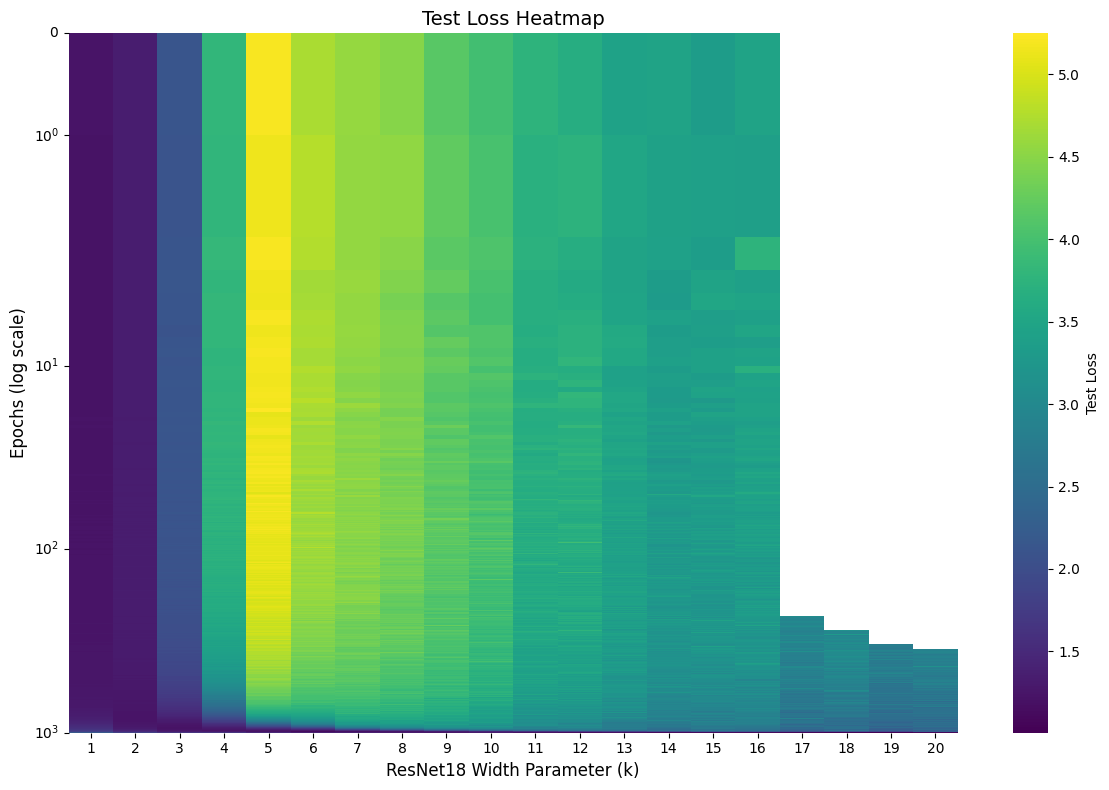

In [1]:
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Specify the path to your run directory
run_dir = "/home/jakub/projects/double_descend/double_descent_torch/runs/run_20241011_115420/results"

# Function to load results
def load_results(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

# Load all results
all_results = []
for filename in os.listdir(run_dir):
    if filename.startswith("resnet18k_") and filename.endswith("_results.json"):
        file_path = os.path.join(run_dir, filename)
        k = int(filename.split("_")[1])  # Extract k value from filename
        results = load_results(file_path)
        for result in results:
            result['k'] = k  # Add k to each result dictionary
        all_results.extend(results)

# Create a DataFrame
df = pd.DataFrame(all_results)

# Pivot the DataFrame for the heatmap
pivot_df = df.pivot(index='epoch', columns='k', values='test_loss')
pivot_df = pivot_df.sort_index(ascending=False)  # Reverse the order of epochs

# Create the heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(pivot_df, cmap='viridis', cbar_kws={'label': 'Test Loss'}, ax=ax)

# Adjust y-axis (Epochs) to logarithmic scale
max_epochs = pivot_df.index.max()
y_ticks = np.logspace(0, np.log10(max_epochs), num=5, dtype=int)
ax.set_yticks(max_epochs - y_ticks + 1)  # Reverse the order
ax.set_yticklabels(y_ticks, fontsize=10)
ax.set_yscale('symlog')  # Use symlog to handle epoch 0
plt.ylabel('Epochs (log scale)', fontsize=12)

# Adjust x-axis (k values)
plt.xticks(fontsize=10)
plt.xlabel('ResNet18 Width Parameter (k)', fontsize=12)

# Title
plt.title('Test Loss Heatmap', fontsize=14)

plt.tight_layout()
plt.show()